In [ ]:
# # To filter by regex:
# df_filtered = df[df['name'].str.contains(pattern_name) | df['country'].str.contains(pattern_city)]

In [93]:
import pandas as pd
import numpy as np
import os
import enchant
import re
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

In [2]:
year = "2019"
filepath = "C:/Users/mlmcp/stopa/data/"
df_list = [pd.read_parquet(filepath+year+"_parquet_logs/"+file) for file in os.listdir(filepath+year+"_parquet_logs/")]
df = pd.concat(df_list, ignore_index=True)

In [3]:
# Manual 2019

# Manually merge 'Di' with '$p' (2019)
row = df[df['text']=='$p-13:30:00'].index[0]
df.at[row, 'text'] = 'Disp-13:30:00'
df.drop([row-1],inplace=True)
df.reset_index(drop=True,inplace=True)

# Manually fix 'Arvd-13:368:23' (2019)
row = df[df['text']=='Arvd-13:368:23'].index[0]
df.at[row,'text'] = 'Arvd-13:36:23'

# Manually fix 'Axyvd-160:19:35' (2019) (Clrd-10:27:04) # df[df['text'].str.startswith('Axyvd-1')]
row = df[df['text']=='Axyvd-160:19:35'].index[0]
df.at[row,'text'] = 'Axyvd-10:19:35'

# Manually fix 'Arvd-17:15:31)' (2019)
row = df[df['text']=='Arvd-17:15:31)'].index[0]
df.at[row,'text'] = 'Arvd-17:15:31'

In [4]:
# Clrd-date // @ // time
pattern_date = re.compile("\d\d/\d\d/\d\d\d\d")
pattern_time = re.compile("\d\d+[:;]+\d\d+[:;]+\d\d+")

df['text2'] = df['text']
df['drop']=0

for i in range(len(df)):
    if pattern_date.search(df['text'][i]): # Checks for date anywhere in text
        if enchant.utils.levenshtein(re.sub(pattern_date,"",df['text'][i]),'Clrd-')<=2: # Find prefix similar to 'Clrd-'
            if (pattern_time.fullmatch(df['text'][i+2])) and (len(df['text'][i+1])==1): # [i+2] is a timestamp and [i+1] looks like @
                df['text2'][i] = 'Clrd-'+pattern_time.search(df['text'][i+2]).group() # .group() returns the matching string
                df['drop'][i+1] = 1
                df['drop'][i+2]= 1

df.drop(df[df['drop'] == 1].index, inplace=True)
df.reset_index(drop=True,inplace=True)

# df[df['text']!=df['text2']]

In [5]:
# Arvd- and timestamp on sucessive rows.
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']

df['text3']=df['text2']

for i in range(len(df)-1):
    if pattern_time.fullmatch(df['text'][i+1]): # Next line is timestamp
        for w in fix_list:
            if enchant.utils.levenshtein(df['text'][i],w)<=2:
                df['text3'][i] = w+df['text'][i+1] # Merge rows
                df['drop'][i+1]=1 # Drop row
        
df.drop(df[df['drop'] == 1].index, inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop('drop', axis=1, inplace=True)

# df[df['text3']!=df['text2']]

In [6]:
# Fix word-timestamp if word is close to 'Arvd', etc.
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']

# New columns
df['text4'] = df['text3']
df['timestamp'] = ''

for i in range(len(df)):
    if pattern_time.search(df['text3'][i]): #Checks for timestamp anywhere in text
        df['timestamp'][i] = pattern_time.search(df['text3'][i])[0]
        for w in fix_list:
            if (enchant.utils.levenshtein(re.sub(pattern_time,"",df['text3'][i]),w)<=2):
                df['text4'][i] = w + pattern_time.search(df['text3'][i])[0]

# df[df['text3']!=df['text4']]
# Note - dist('Arvd','Clrd') = 3 so threshhold needs to be 2

In [7]:
# Manually fix status-timestamp

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_disp = ['$p-'] # Fixed manually above
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

df['text5']=df['text4']

for w in manual_arvd:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Arvd-')

for w in manual_clrd:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Clrd-')

for w in manual_enrt:
    idx = df[df['text4'].str.startswith(w)].index
    for i in idx:
        df['text5'][i] = df['text4'][i].replace(w,'Enrt-')

# df[df['text5']!=df['text4']]

In [8]:
print(df[df['text5'].str.startswith('Disp-')].shape)
print(df[df['text5'].str.startswith('Enrt-')].shape)
print(df[df['text5'].str.startswith('Arvd-')].shape)
print(df[df['text5'].str.startswith('Clrd-')].shape)

(3240, 18)
(2391, 18)
(12136, 18)
(12474, 18)


In [10]:
# Make column for status word

df['status'] = '' # Will be poplulated by Disp, Enrt, Arvd, Clrd
status_list = ['Disp','Enrt','Arvd','Clrd']

for status in status_list:
    idx = df[df['text5'].str.startswith(status+'-')].index
    for i in idx:
        df['status'][i] = status

In [10]:
df[(df['status']!='') & (df['timestamp']=='')].shape

# # ~40 instances of timestamp cut off halfway through, e.g. Arvd-08: // 14: // 12

(308, 19)

In [11]:
df.drop('text2', axis=1, inplace=True)
df.drop('text3', axis=1, inplace=True)
df.drop('text4', axis=1, inplace=True)

In [14]:
# Clean timestamp
df['timestamp'] = df['timestamp'].str.replace(';','')
df['timestamp'] = df['timestamp'].str.replace(':','')

# Note - We are not addressing timestamps that are too many digits
df['hour'] = df['timestamp'].str[0:2]
df['min'] = df['timestamp'].str[2:4]
df['sec'] = df['timestamp'].str[4:6]

In [15]:
# Ignore timestamps that do not make sense. Timestamp --> pandas datetime.
df2 = df[(df['hour'].apply(pd.to_numeric)<24)&(df['min'].apply(pd.to_numeric)<60)&(df['sec'].apply(pd.to_numeric)<60)&(df['status']!='')]
df2['time_clean'] = pd.to_datetime(df2['hour']+':'+df2['min']+':'+df2['sec'],format= '%H:%M:%S' )
df2 = df2.reset_index()

In [74]:
# New df: Each row is a call. 
df3 = pd.DataFrame(columns =['arvd_time','clrd_time'])

idx = df2[df2['status']=='Arvd'].index
for i in idx:
    if df2['status'][i+1] == 'Clrd':
        df3 = pd.concat([df3, pd.DataFrame([[df2['time_clean'][i],df2['time_clean'][i+1]]], columns=df3.columns)], ignore_index=True)

In [76]:
# Limit to calls <2 hours
df4 = df3[(df3['clrd_time']-df3['arvd_time']<'0 days 02:00:00') & (df3['clrd_time']-df3['arvd_time']>'0 days 00:00:00')]
df4.reset_index(drop=True, inplace = True)

In [105]:
# Method 1
df4['daybreak'] = np.where(df4['arvd_time']-df4['arvd_time'].shift(1)<'-1 days 12:00:00', 1, 0)

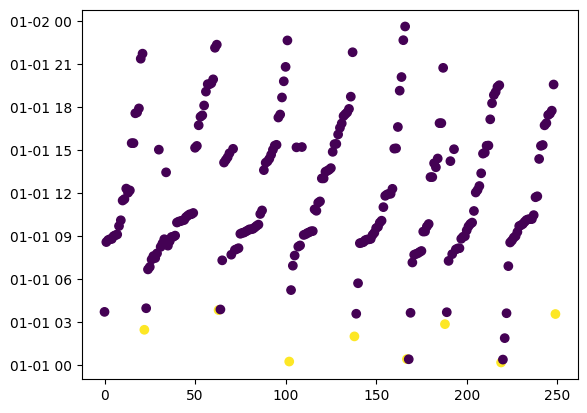

In [107]:
n = 250
plt.scatter(df4.index[0:250],df4['arvd_time'][0:250],c=df4['daybreak'][0:250])

# Method 2

In [110]:
import time
from itertools import cycle, islice

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [ ]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# Plot of arvd-clrd

In [108]:
# n = 50

# plt.figure(figsize=(13,9))
# plt.grid(which = 'both')
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# # plt.xlim(0,24)
# plt.ylim(-0.5,n+10)
# plt.xlabel('Time', fontsize = 16)

# bar_ys = list(range(n))
# bar_xs = df4[0:n].to_numpy().tolist()

# c = 'k'
# for y,xs in zip(bar_ys,bar_xs):
#     plt.annotate('', xy = (xs[0],y), xycoords='data', xytext=(xs[1],y),
#                  arrowprops=dict(arrowstyle='|-|', color=c, lw=2, shrinkA=0, shrinkB=0))
#     plt.annotate('',xy = (xs[1],y), xycoords='data', xytext=(-5,5), textcoords='offset points',
#                  fontsize = 16, va='baseline', ha='right', color=c)

# plt.show()

In [43]:
import matplotlib.dates as mdates

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

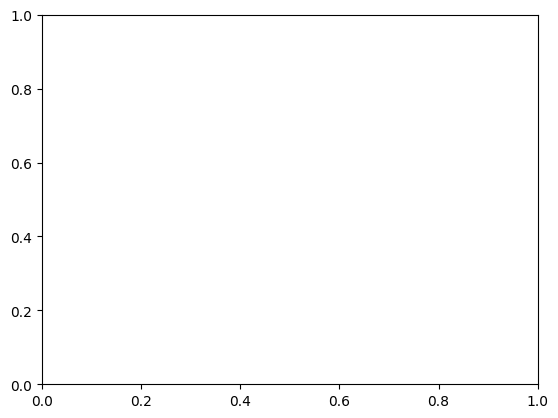

In [80]:
fig, ax = plt.subplots()
ax.set_xlim(mdates.date2num('1900-01-01 00:00:00'),mdates.date2num('1900-01-02 00:00:00'))
for i in [0,1,2,3,4,5]:
# for i in df4.index:
    ax.axhline(y = i, xmin = mdates.date2num(df4.loc[i,'arvd_time']), xmax = mdates.date2num(df4.loc[i,'clrd_time']))

# Less Old

In [ ]:
# If text minus date/timestamp is similar to Arvd, Clrd, etc. --> clean

# If text Arvd/Clrd/etc-timestamp --> transit_time=timestamp

# If text Arvd/Clrd/ect-date and next line is @ and next line is timestamp --> transit_time[i]=timestamp[i+2]

# If text in Arvd, Clrd, etc. but no timestamp and next line is timestamp --> transit_time[i]=timestamp[i+1] 

In [281]:
# If text minus date/timestamp is similar to Arvd, Clrd, etc. --> clean

fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']
pattern = re.compile("\d\d[:/]\d\d[:/]\d\d+")

# New columns
df['text2'] = df['text']

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-', 'Axyvd-']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

for i in range(len(df)):
    for s in fix_list:
        if enchant.utils.levenshtein(re.sub(pattern,"",df['text'][i]),s)<=2:
            df['text2'][i] = df['text'][i].replace(re.sub(pattern,"",df['text'][i]),s)
            
    if re.sub(pattern,"",df['text'][i]) in manual_arvd:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Arvd-',df['text'][i])

    if re.sub(pattern,"",df['text'][i]) in manual_clrd:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Clrd-',df['text'][i])

    if re.sub(pattern,"",df['text'][i]) in manual_enrt:
        df['text2'][i] = re.sub(re.sub(pattern,"",df['text'][i]),'Enrt-',df['text'][i])

df[df['text']!=df['text2']]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text2
308,5,1,20,1,1,1,867,350,286,51,87,Bnrt-11:24:07,3,Enrt-11:24:07
1593,5,1,29,1,1,1,1195,1125,292,51,0,Arvad-08:46:35,7,Arvd-08:46:35
1629,5,1,32,2,1,2,1537,1725,288,52,52,Clird-08:28:55,7,Clrd-08:28:55
1796,5,1,9,1,1,1,1189,725,292,50,0,Arv@a-08:56:46,8,Arvd-08:56:46
1797,5,1,9,1,1,2,1532,725,290,51,86,Cird-08:57:22,8,Clrd-08:57:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583673,5,1,34,1,1,1,1184,1400,288,51,62,Brvd-15:08:29,2370,Arvd-15:08:29
583674,5,1,34,1,1,2,1522,1400,285,51,25,Cird-15:11:34,2370,Clrd-15:11:34
584006,5,1,26,4,1,4,1554,1950,286,55,31,Clrdg-17:40:39,2371,Clrd-17:40:39
584008,5,1,26,4,1,2,882,1975,288,55,16,Bnrt-17:21:15,2371,Enrt-17:21:15


## Old

In [6]:
# Merge timestamps without text with preceding row

# New columns
df['text_merge']=df['text']
df['discard']=0

pattern = re.compile("\d\d:\d\d:\d\d")

for i in range(len(df)-1):
    if pattern.match(df['text'][i+1]): #Checks for timestamp at front
        df['text_merge'][i] = df['text'][i]+df['text'][i+1]
        df['discard'][i+1]=1

In [7]:
# Fix timestamp words
fix_list = ['Arvd-', 'Clrd-', 'Disp-', 'Enrt-']
pattern = re.compile("\d\d:\d\d:\d\d")

# New columns
df['text2'] = df['text_merge']
df['timestamp'] =''
df['text_alpha'] = ''

manual_arvd = ['Arv@a@-','AQGVG-', 'AYrvVG-','ArVG-2','AxcvG-', 'AvVG-', 'ArvVG+','AQVG-','AYVG-', 'ATVG-O', 'Arwd-+-', 'Axyvd-1']
manual_clrd = ['Circd-+','Cirag-', 'Ciryrd-','Cird-+-','Cirdad-']
manual_disp = ['$p-']
manual_enrt = ['S&mrt-','EBnxet-','Bnvte-', 'Bnrce-', 'BRrevd-','Bnxyt-']

for i in range(len(df)):
# Run for loop on lines with criteria
    if pattern.search(df['text_merge'][i]): #Checks for timestamp anywhere in text
        df['timestamp'][i] = pattern.search(df['text_merge'][i])[0]
        for s in fix_list:
            if (enchant.utils.levenshtein(re.sub(pattern,"",df['text_merge'][i]),s)<=2):
                df['text2'][i] = s + pattern.search(df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_arvd:
        df['text2'][i] = 'Arvd-' + pattern.search(df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_clrd:
        df['text2'][i] = 'Clrd-' + re.search(pattern,df['text_merge'][i])[0]

    if re.sub(pattern,"",df['text_merge'][i]) in manual_enrt:
        df['text2'][i] = 'Enrt-' + re.search(pattern,df['text_merge'][i])[0]

    df['text_alpha'][i] = re.sub(pattern,"",df['text2'][i])

# Check
df_ts = df[df['timestamp']!='']
df_ts['text_alpha'].value_counts()
# df_ts['text_alpha'].unique()

# Note - dist('Arvd','Clrd') = 3 so threshhold needs to be 2

text_alpha
Clrd-        12149
Arvd-        11709
Disp-         3148
Enrt-         2353
                97
@               47
©                3
-                2
21A0G2019        1
21AUG2019        1
©@               1
Name: count, dtype: int64

In [38]:
# Example of a merge fix
df.iloc[11025:11027] #2019

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text_merge,discard,text2,timestamp,text_alpha
11025,5,1,73,1,1,1,1186,2400,106,49,91,Arvd-,45,Arvd-08:32:54,0,Arvd-08:32:54,08:32:54,Arvd-
11026,5,1,73,1,1,2,1303,2400,173,48,96,08:32:54,45,08:32:54,1,08:32:54,08:32:54,


In [16]:
# df[(df['text_merge']!=df['text2']) and (df['text_alpha']==" ")]
# # df[(df['text']!=df['text_merge'])]
# # df.iloc[7619:7623] #2019 Clrd-date
# # # df.iloc[16806:16809] #2019
# # # df[df['text']=='@']
# # # df.iloc[435:446]

df.iloc[7615:7630]
df[df['text_alpha']==""]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,text_merge,discard,text2,timestamp,text_alpha
7621,5,1,10,1,10,1,12,1375,173,50,96,00:01:00,32,00:01:00,1,00:01:00,00:01:00,
11026,5,1,73,1,1,2,1303,2400,173,48,96,08:32:54,45,08:32:54,1,08:32:54,08:32:54,
12325,5,1,26,3,1,3,1644,2500,175,49,96,03:33:06,50,03:33:06,1,03:33:06,03:33:06,
16808,5,1,3,1,4,1,14,150,172,51,95,00:02:20,69,00:02:20,1,00:02:20,00:02:20,
18907,5,1,20,1,1,1,0,2525,171,50,95,00:02:58,78,00:02:58,1,00:02:58,00:02:58,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570643,5,1,3,1,1,1,4,475,172,49,90,00:34:05,2314,00:34:05,1,00:34:05,00:34:05,
570649,5,1,3,2,1,1,4,600,172,47,52,00:24:54,2314,00:24:54,1,00:24:54,00:24:54,
573422,5,1,15,1,1,1,4,2075,172,49,93,00:03:39,2325,00:03:39,1,00:03:39,00:03:39,
580179,5,1,1,1,35,1,2,1750,172,49,95,00:01:22,2354,00:01:22,1,00:01:22,00:01:22,


In [19]:
# df[df['text']=='@'].shape # 1% of text (5,980 rows) is '@'
# df[df['text']=='@']['text_merge'].value_counts() # Most (5,933) @ not followed by timestamp
# When @ followed by timestamp, it is usually clrd-date @ time (just after midnight). Example:
df.iloc[7618:7623] #2019

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,pdf_page,date
7618,5,1,10,1,9,1,1201,1325,291,52,76,Arvd-23:56:15,32,0
7619,5,1,10,1,9,2,1543,1325,335,57,76,Clrd-01/06/2019,32,1
7620,5,1,10,1,9,3,1903,1350,22,47,92,@,32,0
7621,5,1,10,1,10,1,12,1375,173,50,96,00:01:00,32,0
7622,5,1,10,1,11,1,255,1400,170,50,96,Vehicle:,32,0


In [180]:
# Pair Arvd & Clrd.
# 2019 dataset: df_arvd is 11,707, df_clrd is 12,148
# Idea: Pair arvd with next clrd. Pair clrd with the arvd that was assigned to it.

df_arvd = df[df['text_alpha']=='Arvd-']
df_clrd = df[df['text_alpha']=='Clrd-']

# for i in df_arvd.index:
#     # Set df['time_clrd'][i] to next occurence in df[beyond row i] of clrd

# df[df['timestamp']>'24:00:00'].head(20)
# df[df['timestamp']!=''].head(20)

(12148, 16)

In [ ]:
# Next step: Text clustering with k-means
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
# Center = most frequent spelling?

In [95]:
# # Strings that end in hh:mm:ss
# pattern = re.compile("\d\d:\d\d:\d\d")
# timestamp_words = []
# for i in range(len(df)):
#     if pattern.search(df['text'][i]):
#         timestamp_words.append(re.sub(pattern,"",df['text'][i]))

# timestamp_words = pd.DataFrame(timestamp_words)
# timestamp_words[0].unique()